<a href="https://colab.research.google.com/github/bangse94/StudyDL/blob/main/Pytorch_tutorial_2_Dataset_and_DataLoader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DATASET과 DATALOADER
  - 데이터 샘플을 처리하는 코드는 지저분하고 유지보수가 어려울 수 있다.
  - 더 나은 가독성과 모듈성을 위해 데이터셋 코드를 모델 학습 코드로부터 분리하는 것이 이상적이다.
  - PyTorch는 torch.utils.data.DataLoader 와 torch.utils.Dataset 의 두가지 데이터 기본 요소를 제공하여 pre-loaded 데이터셋 뿐만 아니라 가지고 있는 데이터를 사용 할 수 있도록 한다.
  - Dataset은 샘플과 label을 저장하고, DataLoader는 Dataset 샘플에 쉽게 접근 할 수 있도록 순회 가능한 객체(iterable)로 감싼다

  1. 데이터셋 불러오기
    - TorchVision에서 Fashion-MNIST 데이터 셋을 불러오는 예제
    - 다음 매개변수를 사용하여 FashionMNIST 데이터셋을 불러온다.
      - root는 학습/테스트 데이터가 저장되는 경로
      - train은 학습용 또는 테스트용 데이터셋 여부를 지정
      - download=True는 root에 데이터가 없는 경우 인터넷에서 다운로드
      - transform과 target_transform은 feature와 label transform을 지정

In [19]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
    root = "data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  2. 데이터셋을 순회하고 시각화하기
    - Dataset에 list처럼 직접 접근 할 수 있다 : training_data[index], matplotlib을 사용하여 데이터를 시각화

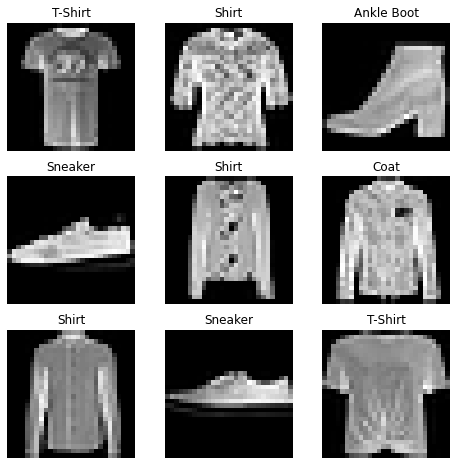

In [23]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8,8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

  3. 파일에서 사용자 정의 데이터셋 만들기
    - 사용자 정의 Dataset 클래스는 반드시 3개의 함수를 구현해야 한다.
    - __init__, __len__, __getitem__
    - 아래 구현에서는 FashionMNIST 이미지들은 img_dir 디렉토리에 저장되고, label은 annotation_file csv 파일에 별도로 저장된다

In [24]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self,img_labels = pd.read_csv(annotations_file, names=['file_name', 'label'])
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)
        
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx,0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

  4. DataLoader로 학습용 데이터 준비하기
    - Dataset은 데이터셋의 feature를 가져오고 하나의 샘플에 label을 지정하는 일을 한 번에 한다.
    - 모델을 학습 할 때, 일반적으로 샘플들은 미니배치로 전달하고, 매 epoch마다 데이터를 다시 섞어서 overfit를 막고, Python의 multiprocessing을 사용하여 검색 속도를 높이려 한다.
    - DataLoader는 간단한 API로 위와같은 복잡한 과정들을 추상화한 순회 가능한 iterable이다.

In [25]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

  5. DataLoader를 통해 순회하기(iterate)
    - DataLoader에 데이터셋을 불러온 뒤에는 필요에 따라 데이터셋을 순회 할 수 있다.
    - 아래의 각 순회(iteration)은 train_features와 train_labels의 묶음(batch)를 반환한다.
    - shuffle=True이므로, 모든 배치를 순회한 뒤 데이터를 셔플한다.

Feature batsh shape : torch.Size([64, 1, 28, 28])
Labels batch shape : torch.Size([64])


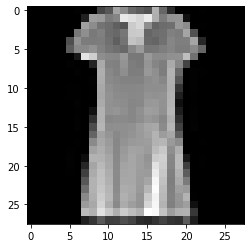

Label: 3


In [26]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batsh shape : {train_features.size()}")
print(f"Labels batch shape : {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")